# Tutorial 3: Mouse Brain Dataset

In this tutorial, we evaluate SpaKnit's capabilities on capturing diverse spatial patterns and achieving appropriate spatial smoothness. We analyzed four slices from the **mouse brain dataset** generated by spatial ATAC-RNA-seq and spatial CUT&Tag-RNA-seq, which exhibits strong spatial patterns.

All datasets used in this paper are available at https://doi.org/10.5281/zenodo.14854747.

## Loading package

In [1]:
import warnings
warnings.filterwarnings('ignore')
import torch
import anndata
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import csr_matrix

import sys
sys.path.append(r'..')
from Model.INR import INRModel
from Model.utils import reorder_categories
from Model.model import DCCAE
from Model.preprocess import fix_seed, preprocessing
fix_seed(2024)

## Loading and preprocessing data

In [2]:
adata_modality_1 = sc.read_h5ad("../Data/Mouse_Brain_ATAC/adata_RNA.h5ad")
adata_modality_2 = sc.read_h5ad("../Data/Mouse_Brain_ATAC/adata_peaks_normalized.h5ad")

adata_modality_1.var_names_make_unique()
adata_modality_2.var_names_make_unique()

fix_seed(2024)
adata_modality_1, adata_modality_2 = preprocessing(adata_modality_1, adata_modality_2, 'Spatial-epigenome-transcriptome')
adata_modality_1.X = adata_modality_1.uns['INR']
adata_modality_2.obsm['X_pca'] = adata_modality_2.uns['INR']
sc.pp.pca(adata_modality_1)

Spatial-epigenome-transcriptome data preprocessing have done!
Dimensions after preprocessed adata_modal_1: (9196, 3000)
Dimensions after preprocessing adata_modal_2: (9196, 121068)


## Training the model

### INR module

All parameters of the INR model (except for the number of training epochs) remain the same across the four slices.

| slice | epoch of modality 1 | epoch of modality 2 |
|:------:|:------:|:------:|
| ATAC | 1500  | 200   |
| H3K27me3 | 1500 | 200   |
| H3K27ac | 1500 | 200   |
| H3K4me3 | 1500  | 500   |

In [ ]:
## INR module training
def Spatially_Continuous_Reconstruction(adata, epoch_num):
    coords = adata.obsm['spatial'].astype(np.float32)
    node_feats = adata.X.astype(np.float32)

    coords = torch.from_numpy(coords).float()
    if isinstance(node_feats, csr_matrix):
        node_feats = node_feats.toarray()
    node_feats = torch.from_numpy(node_feats).float()
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    node_feats = node_feats.to(device)
    coords = coords.to(device)
    
    print(f'out_dim: {node_feats.shape[1]}')

    model = INRModel(
        X=node_feats,
        spatial_coord=coords,
        device=device,
        learning_rate=1e-4,
        reg_par=0,
        epoch_num=epoch_num,
        print_train_log_info=True
    )

    reconstructed_X = model.fit()
    if 'INR' not in adata.uns:
        adata.uns['INR'] = reconstructed_X

# modality 1
Spatially_Continuous_Reconstruction(adata_modality_1, 1500)

# modality 2
Spatially_Continuous_Reconstruction(adata_modality_2, 200)

### DCCAE module

In [6]:
n_output = 30
features1 = adata_modality_1.obsm['X_pca'].shape[1]  # Feature sizes
features2 = adata_modality_2.obsm['X_pca'].shape[1]
layers1 = [256, 256, n_output]  # nodes in each hidden layer and the output size
layers2 = [256, 256, n_output]

X = adata_modality_1.obsm['X_pca']
Y = adata_modality_2.obsm['X_pca']

use_rep = ['DCCAE_X', "DCCAE_Y", "DCCAE"]
n_DCCA = 10
epochs = 60
model = DCCAE(input_size1=features1, input_size2=features2, n_components=n_DCCA, layer_sizes1=layers1, layer_sizes2=layers2, epoch_num=epochs)
model.fit([X, Y])
Xs_transformed = model.transform([X, Y])
adata_modality_1.obsm["DCCAE_X"] =  Xs_transformed[0]
adata_modality_2.obsm["DCCAE_Y"] =  Xs_transformed[1]
adata_modality_1.obsm["DCCAE"] = np.concatenate((adata_modality_1.obsm["DCCAE_X"], adata_modality_2.obsm["DCCAE_Y"]),axis=1)

Training Progress: 100%|██████████| 60/60 [00:32<00:00,  1.84it/s]


model training finished!


In [ ]:
sc.pp.neighbors(adata_modality_1, use_rep=use_rep[2])
# resolution should be adjusted to keep the suitable number of clusters
sc.tl.leiden(adata_modality_1, key_added="clusters_leiden", resolution=0.7)
adata_modality_1.obs["clusters_leiden"]

CTAAGGTCAACGTGAT    4
CTAAGGTCACAAGCTA    1
CTAAGGTCTTGCTGGA    5
CTAAGGTCCTGTAGCC    1
CTAAGGTCAGTACAAG    1
                   ..
GAACAGGCGATGAATC    8
GAACAGGCGCCAAGAC    8
GAACAGGCCGGAAGAA    8
GAACAGGCGTGACAAG    8
GAACAGGCGAACCAGA    8
Name: clusters_leiden, Length: 9732, dtype: category
Categories (13, object): ['0', '1', '2', '3', ..., '9', '10', '11', '12']

## Visualization and Analysis

### Spatially continous restruction using the INR module

In [ ]:
X1 = adata_modality_1.X
X1 = np.sum(X1, axis=1)
print(np.shape(X1))


X2 = adata_modality_1.uns['INR']
X2 = np.sum(X2, axis=1)
print(np.shape(X2))

coords = adata_modality_1.obsm['spatial']
print(np.shape(coords))

## Calculate the absolute value of the gradient
data_df = pd.DataFrame({
    'x': coords[:, 0],
    'X1': X1,
    'X2': X2
})

sum_by_x = data_df.groupby('x')[['X1', 'X2']].sum().reset_index()
scaler = MinMaxScaler()
sum_by_x[['X1', 'X2']] = scaler.fit_transform(sum_by_x[['X1', 'X2']])


gradient_X1 = np.gradient(sum_by_x['X1'])
gradient_X2 = np.gradient(sum_by_x['X2'])

abs_gradient_X1 = np.abs(gradient_X1).sum()
abs_gradient_X2 = np.abs(gradient_X2).sum()

print(abs_gradient_X1)
print(abs_gradient_X2)

(9196,)
(9196,)
(9196, 2)
4.915473
3.3492827


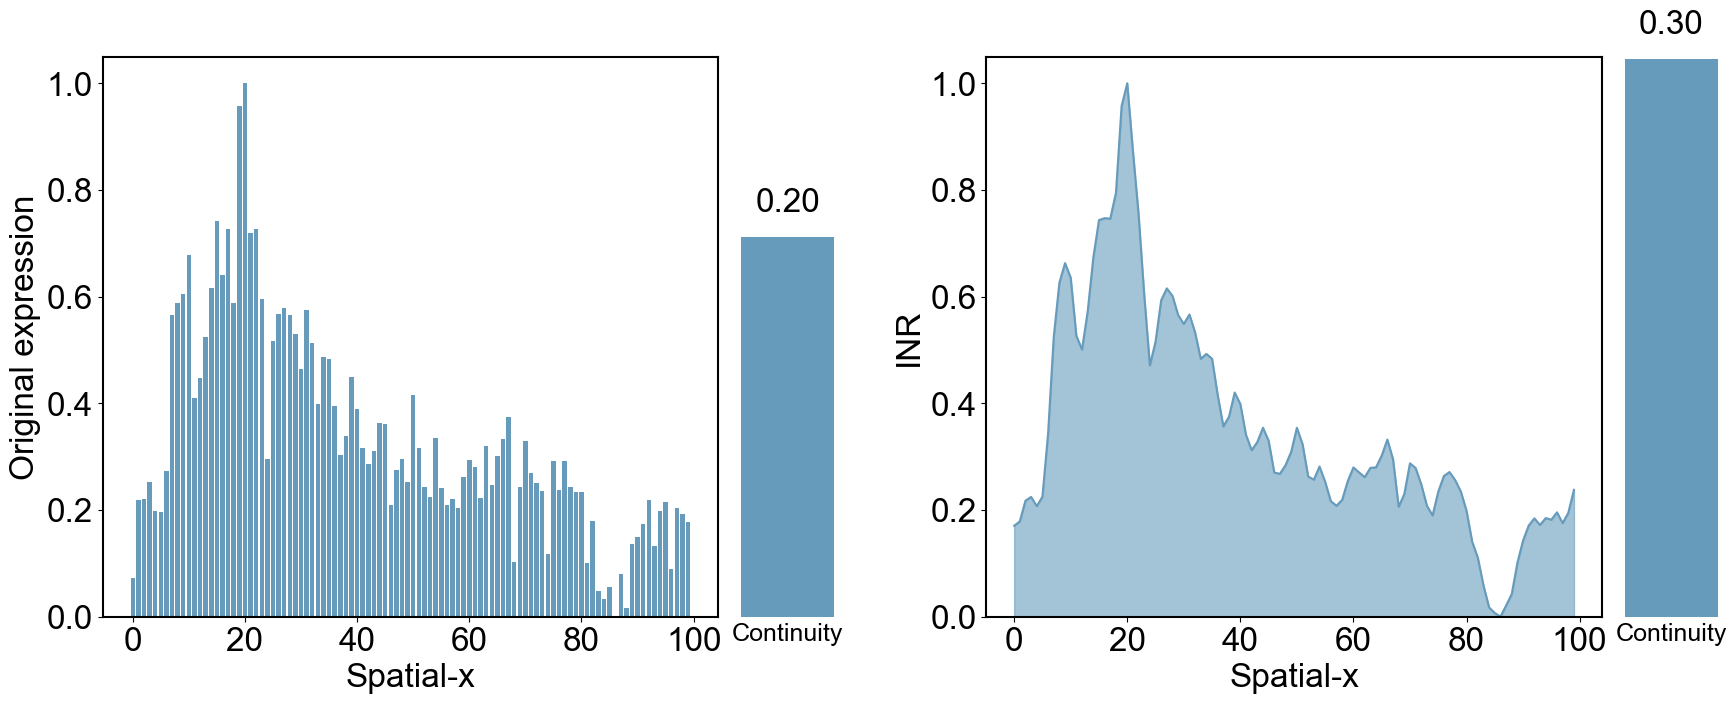

In [ ]:
# Create a figure
fig = plt.figure(figsize=(18, 7))

# Create an outer GridSpec to define the overall layout of the figure
outer_gs = GridSpec(1, 2, width_ratios=[9, 9], wspace=0.2)

# Create the first inner GridSpec, containing the first and second subplots
inner_gs1 = GridSpecFromSubplotSpec(1, 2, subplot_spec=outer_gs[0], width_ratios=[6, 1], wspace=0.05)

# Create the second inner GridSpec, containing the third and fourth subplots
inner_gs2 = GridSpecFromSubplotSpec(1, 2, subplot_spec=outer_gs[1], width_ratios=[6, 1], wspace=0.05)

color = '#669bbc'

# Set the global font to Arial and the global font size
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 24

# Plot the first subplot: Bar chart of X1
ax1 = fig.add_subplot(inner_gs1[0])
ax1.bar(sum_by_x['x'], sum_by_x['X1'], color=color)
ax1.set_xlabel('Spatial-x')
ax1.set_ylabel('Original expression')
ax1.set_ylim(0, 1.05)  # Set the y-axis range
for spine in ax1.spines.values():
    spine.set_linewidth(1.5)  # Thicken the border

# Plot the second subplot: Bar chart of the absolute gradient of X1
ax2 = fig.add_subplot(inner_gs1[1])
bar2 = ax2.bar(['X1'], [1/abs_gradient_X1], color=color)
ax2.set_ylim(0, 0.3)  # Set the y-axis range
ax2.set_xlabel('Continuity', fontsize=18)  # Show x-axis ticks
ax2.set_xticks([])  # Do not show y-axis tick lines
ax2.set_yticklabels([])  # Do not show y-axis tick labels
ax2.set_yticks([])  # Do not show y-axis tick lines
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
# Display value labels above the bars
for bar in bar2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

# Plot the third subplot: Line chart of X2 with filled area under the curve
ax3 = fig.add_subplot(inner_gs2[0])
ax3.plot(sum_by_x['x'], sum_by_x['X2'], color=color, linestyle='-')
ax3.fill_between(sum_by_x['x'], sum_by_x['X2'], color=color, alpha=0.6)
ax3.set_xlabel('Spatial-x')
ax3.set_ylabel('INR')
ax3.set_ylim(0, 1.05)  # Set the y-axis range
for spine in ax3.spines.values():
    spine.set_linewidth(1.5)  # Thicken the border

# Plot the fourth subplot: Bar chart of the absolute gradient of X2
ax4 = fig.add_subplot(inner_gs2[1])
bar4 = ax4.bar(['X2'], [1/abs_gradient_X2], color=color)
ax4.set_ylim(0, 0.3)  # Set the y-axis range
ax4.set_xlabel('Continuity', fontsize=18)  # Show x-axis ticks
ax4.set_xticks([])  # Do not show tick lines
ax4.set_yticklabels([])  # Do not show y-axis tick labels
ax4.set_yticks([])  # Do not show y-axis tick lines
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['bottom'].set_visible(False)
ax4.spines['left'].set_visible(False)
# Display value labels above the bars
for bar in bar4:
    yval = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

plt.subplots_adjust(left=0.07, right=0.97, top=0.95, bottom=0.15)

plt.show()

### Spatial domain identification

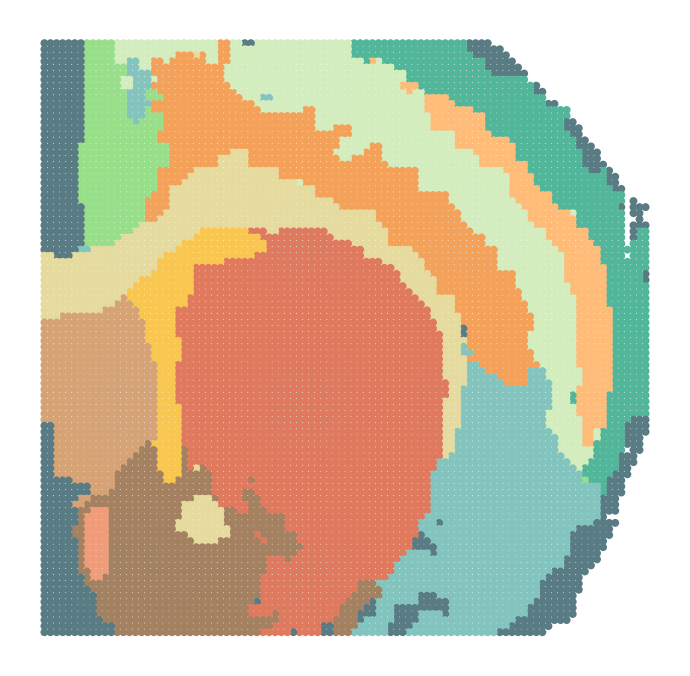

In [ ]:
import scanpy as sc
adata_analysis = sc.read_h5ad("D:/study/learning/spatial_transcriptome/papers/spatial_multi_omics-main/Results/Mouse_Brain_ATAC.h5ad")

## visualization of clustering
colors = [
    '#e07a5f', '#83c5be', '#d3edbe',  '#f4a259', '#597b84', '#a38161', '#e6db9e','#52b69a',
    '#d5a376', '#ffbb78', '#98df8a', '#f9c74f', '#F19C79'
]

fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))
sc.pl.spatial(adata_analysis, img_key="hires", color=['SpaKnit'], spot_size=1.3, ax=ax, show=False, palette=colors)
ax.invert_yaxis()
ax.set_title(f'')
ax.set_xlabel('')
ax.set_ylabel('')
# remove legend
ax.get_legend().remove()
for spine in ax.spines.values():
    spine.set_visible(False)
plt.tight_layout()

### Identifying the marker genes

In [ ]:
## calculate the marker genes
sc.tl.dendrogram(adata_modality_1, groupby='clusters_leiden')
sc.tl.rank_genes_groups(adata_modality_1, groupby='clusters_leiden', use_raw=False)

rank_genes = sc.get.rank_genes_groups_df(adata_modality_1, group=None)
# rank_genes.to_excel("./Results/Visualization/Mouse_Brain/ATAC/" + 'ATAC_marker_genes.xlsx', index=True)

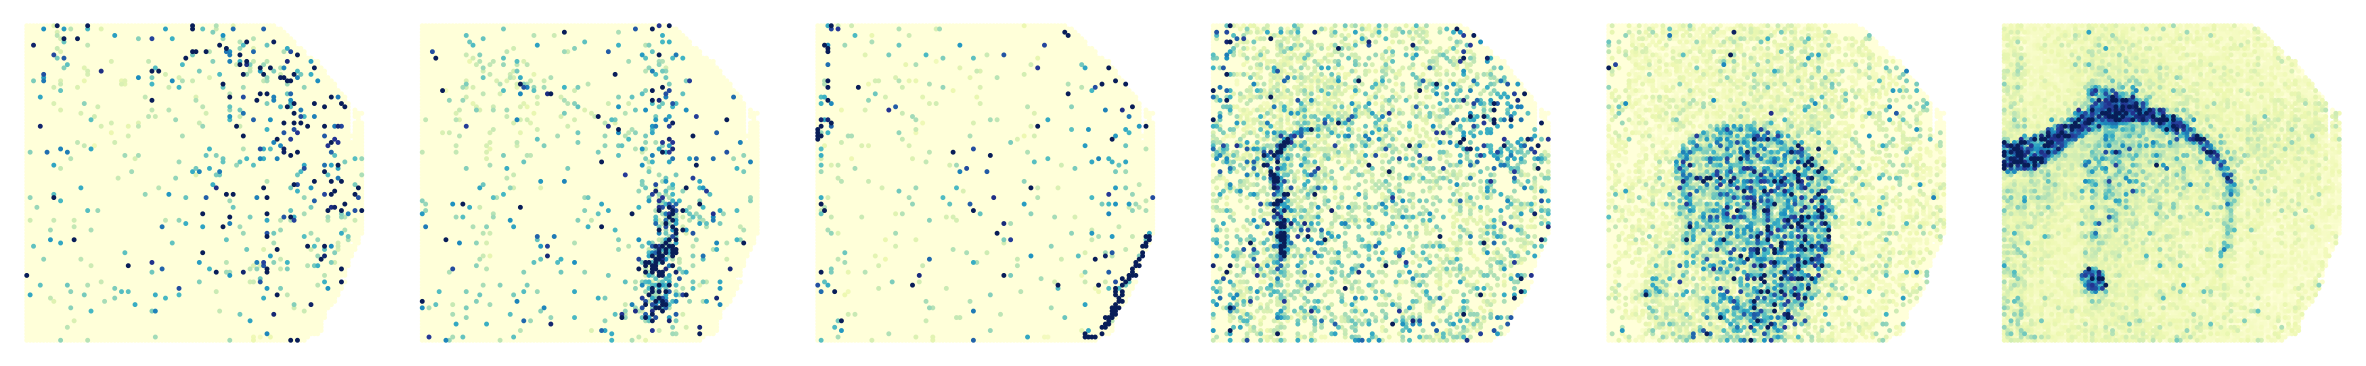

In [ ]:
gene_list = ['Cpne9', 'Nr4a2', 'Myh11', 'Sox4', 'Pde10a', 'Plp1']
replicate = 'ATAC'
adata_modality_1 = sc.read_h5ad(f"D:/study/learning/spatial_transcriptome/papers/spatial_multi_omics-main/data/Mouse_Brain_{replicate}/adata_RNA.h5ad")
sc.pp.filter_genes(adata_modality_1, min_cells=10)
sc.pp.filter_cells(adata_modality_1, min_genes=200)
sc.pp.highly_variable_genes(adata_modality_1, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata_modality_1, target_sum=1e4)

num_genes = len(gene_list)  # Number of genes

plt.rcParams['font.size'] = 18
plt.rcParams['font.sans-serif'] = 'Arial'

# Create a row of subplots
fig, axs = plt.subplots(1, num_genes, figsize=(num_genes * 4, 4), squeeze=False)

# Iterate over the gene list and create a subplot for each gene
for i, gene in enumerate(gene_list):
    expression = adata_modality_1[:, gene].X.toarray().flatten()
    adata_modality_1[:, gene].X = replace_extreme_values(expression, n=0.01)
    sc.pl.embedding(adata_modality_1, basis='spatial', color=gene, ax=axs[0, i], s=50, colorbar_loc=None, show=False, cmap='YlGnBu')
    
    # Remove the spines of the subplot
    for spine in axs[0, i].spines.values():
        spine.set_visible(False)
    
    # Remove x and y axis labels
    axs[0, i].set_xlabel('')
    axs[0, i].set_ylabel('')
    axs[0, i].set_title('')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0, hspace=0)

plt.tight_layout()

In [ ]:
new_orders = ["3", "2", "9", "7", "1", "10", "4", "8", "11", "0", "12", "5", "6"]

reorder_categories(adata_analysis, 'SpaKnit', new_orders)

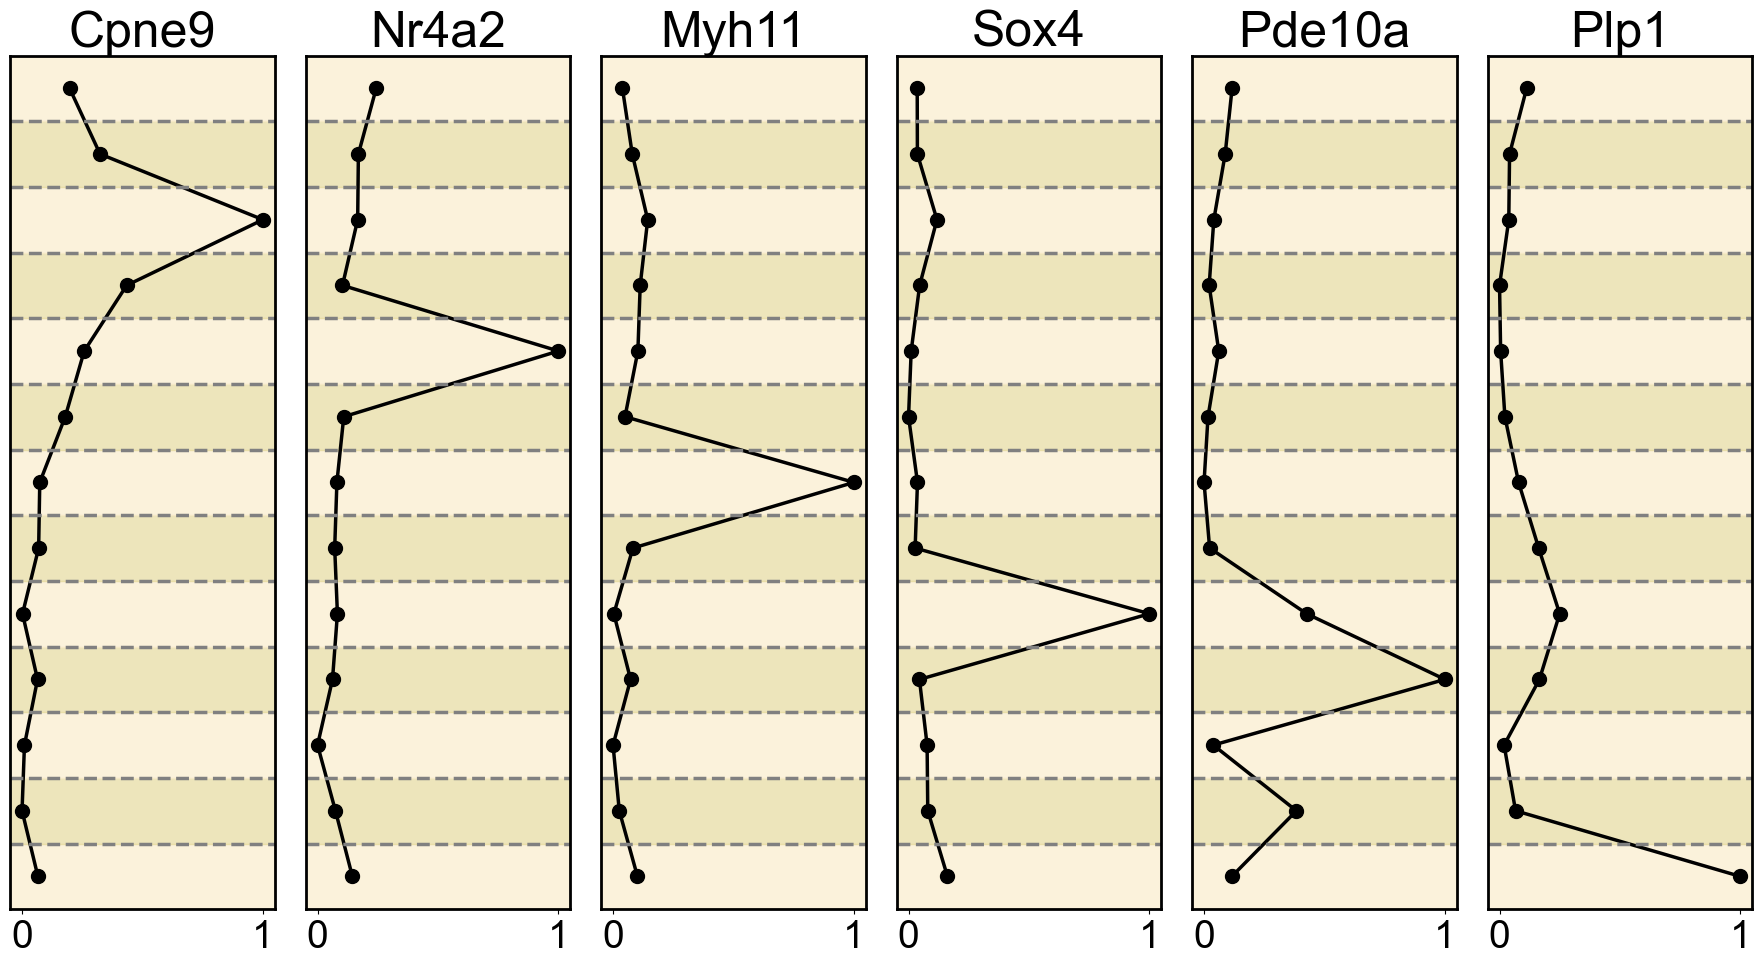

In [ ]:
# Set the figure size and subplot layout
fig, axes = plt.subplots(nrows=1, ncols=len(gene_list), figsize=(len(gene_list) * 3, 10))

colors = ['#faedcd', '#e6db9e']

# Iterate over the gene list and create a subplot for each gene
for i, gene in enumerate(gene_list):
    # Extract the expression data for the target gene
    gene_expression = adata_modality_1[:, gene].X.toarray()
    
    # Convert the expression data to a pandas Series
    gene_expression_series = pd.Series(gene_expression.flatten(), index=adata_modality_1.obs.index)
    
    # Extract cell type labels
    cell_types = adata_analysis.obs['SpaKnit']
    
    # Merge gene expression data and cell type labels into a DataFrame
    df = pd.DataFrame({'gene_expression': gene_expression_series, 'cell_type': cell_types})
    
    # Group by cell type and calculate the mean gene expression for each group
    mean_expression_by_cell_type = df.groupby('cell_type')['gene_expression'].mean()
    
    # Normalize the mean expression values to the range [0, 1]
    scaler = MinMaxScaler()
    normalized_expression = scaler.fit_transform(mean_expression_by_cell_type.values.reshape(-1, 1)).flatten()
    
    # Plot the normalized line chart
    ax = axes[i]  # Get the current subplot axis object
    ax.plot(normalized_expression, mean_expression_by_cell_type.index, marker='o', color='black', linewidth=2.5, markersize=10)
    ax.set_yticks([])  # Remove y-axis labels
    ax.set_ylim([-0.5, 12.5])  # Set y-axis limits
    ax.invert_yaxis()  # Invert the y-axis
    ax.set_xlim(-0.05, 1.05)  # Set x-axis limits
    ax.set_xticks([0, 1])  # Display only 0 and 1 on the x-axis
    ax.tick_params(axis='x', labelsize=28)
    
    ax.set_title(gene, fontsize=36)
    for spine in ax.spines.values():
        spine.set_linewidth(2)  # Set the border line width to 2
    y_min, y_max = ax.get_ylim()
    num_intervals = 13
    y_intervals = np.linspace(y_min, y_max, num_intervals + 1)
    for j in range(num_intervals):
        lower_bound = y_intervals[j]
        upper_bound = y_intervals[j + 1]
        # Select color using modulo operation
        color = colors[j % 2]
        ax.axhspan(lower_bound, upper_bound, color=color, alpha=0.7)
        # Draw a gray dashed line at the upper boundary of each interval
        if j < num_intervals - 1:  # Avoid drawing at the upper boundary of the last interval
            ax.axhline(upper_bound, color='gray', linestyle='--', linewidth=2.5, alpha=1)

plt.tight_layout()